# roAp Classification using regression techniques:
    ~ The classification uses a threshold value of 1.5 for all the regressions
### Updates:
* initial: (03/2/2023)
* linear regression: (04/4/2023)
* classification: (04/13/2023)
* polynomial regression classification: (04/18/22023)
* added lasso regression classification: (04/19/2023)
### Needed:
* add poly to generic and FOV plot w roAp and cluster, just to see what's up
* finish project off with adding elastic-net regression and possibly doing a learning curve
* logistic regression possibly??

In [1]:
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [2]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 122)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 91)


C:\Users\bowcr\AppData\Local\Temp\ipykernel_9260\1649100.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  all['designation'] = all['designation'].str.replace(r'\D', '')


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### ~ Plotting the initial HRD with the field roAps and NGC 2264

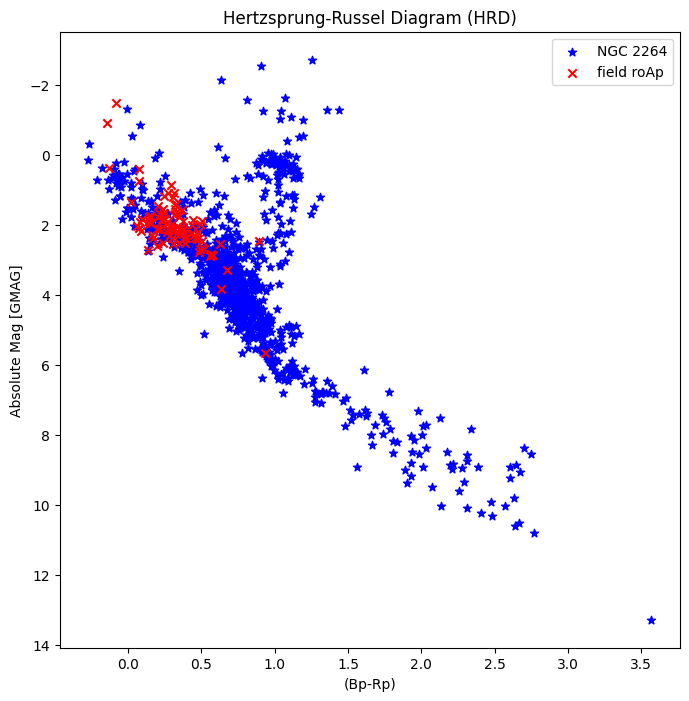

In [3]:
plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()

plt.scatter(x=xc,y=yc,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='x', c='r', label='field roAp')

plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.show()

----

### 2. Splitting the data to be used for training and showing the sizes

In [4]:
# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


----

### 3. Training the Linear Regression model and plotting with the HRD
        Do this but with polynomial, lets see what the cluster gives!

Coefficient for roAp or slope(m) in y = mx+b: [3.28762949]
Coefficient for cluster or slope(m) in y = mx+b: [3.20739619]

Mean squared error for roAp: 0.22
Mean squared error for cluster: 2.56

Coefficient of determination for roAp: 0.13
Coefficient of determination for cluster: 0.28


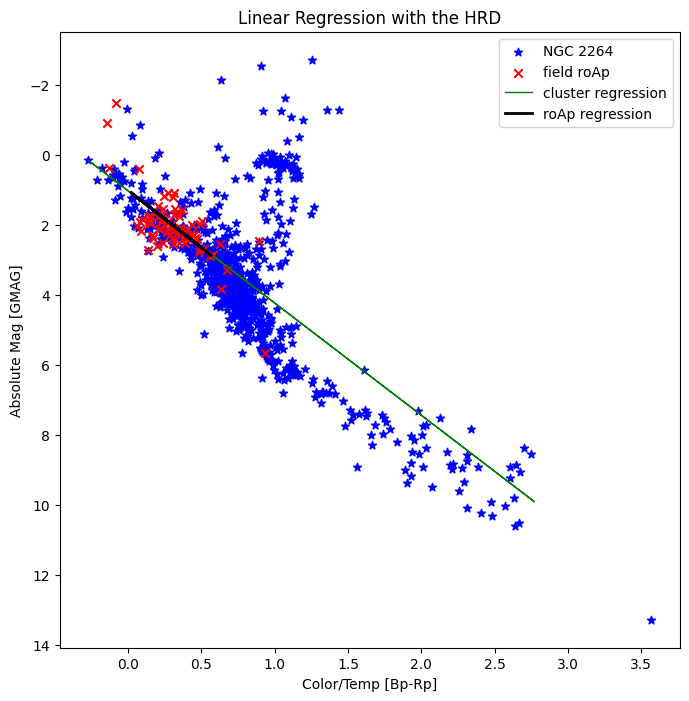

In [5]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(8,8))
plt.gca().invert_yaxis()
plt.title('Linear Regression with the HRD')

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='x', c='r', label='field roAp')
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

----

### 4. Training and plotting the concatenated dataset with the linear regression

#### ~ The following shows the FOV we want to apply the regresion models to, with the cluster data:

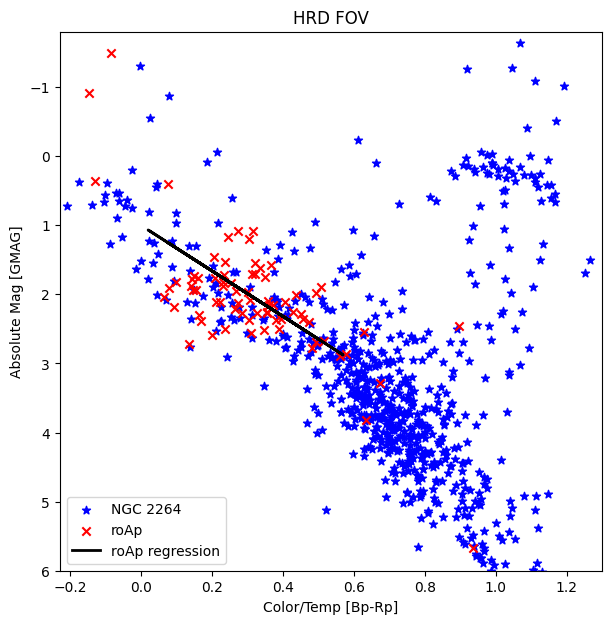

In [6]:
plt.figure(figsize=(7,7))
plt.title('HRD FOV')

plt.ylim([-1.8,6])
plt.xlim([-0.23,1.3])

plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')

plt.gca().invert_yaxis()

plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

#### ~ Fitting the roAp's regression to the concatenated dataset and finding the deviations:

In [7]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)
pred = regr.predict(xtrain)
predr = regr.predict(xtrain_r)

print("Regression Coefficient:", regr.coef_[0])
dist = np.abs(ytrain - pred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 3.2876294914386808
Length of the deviation list: 846


#### ~ Computing which cluster stars are potential candidates using the deviations, threshold value, and the maximum B-R value:

In [8]:
print('Stars in NGC 2264 following the Linear regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Linear regression:
Deviation: 0.23243724394359733 | ID: 108 | GMAG: 3.168816 | B-R:  0.5871736591540849
Deviation: 1.2899410631224488 | ID: 116 | GMAG: 1.817156 | B-R:  -0.14562297302498434
Deviation: 1.072026984674472 | ID: 117 | GMAG: 1.780438 | B-R:  0.5616495629624519
Deviation: 1.3909248699884529 | ID: 126 | GMAG: 2.213628 | B-R:  -0.05574417314699416
Deviation: 0.8553716784818366 | ID: 132 | GMAG: 0.64592 | B-R:  0.1506624642911365
Deviation: 1.499143041106664 | ID: 141 | GMAG: 2.864242 | B-R:  0.10923665279286392
Deviation: 1.3987900917037293 | ID: 143 | GMAG: 1.431744 | B-R:  -0.2959626113170687
Deviation: 0.5181976646049113 | ID: 153 | GMAG: 2.458177 | B-R:  0.2840983207511297
Deviation: 1.1193603596047974 | ID: 208 | GMAG: 1.948123 | B-R:  -0.053901048671004655
Deviation: 1.2571683445911281 | ID: 215 | GMAG: 1.723426 | B-R:  -0.16416438154666183
Deviation: 1.2058371788521827 | ID: 242 | GMAG: 6.609363 | B-R:  1.3376070858878804
Deviation: 1.313

### 5. Exporting potential candidates

#### ~ Writing the data to a csv file:

In [9]:
print(len(cands))
df = pd.DataFrame(cands)
df.to_csv('Data/linear-candidates.csv',index=False,header=True)
df.describe()

49


,ID,Deviation,GMAG,B-R
count,49.000000,49.000000,49.000000,49.000000
mean,521.693878,0.930531,2.568656,0.356938
std,271.092328,0.427314,1.541944,0.391670
min,108.000000,0.070309,-0.228720,-0.346269
25%,317.000000,0.669774,1.723426,0.135076
50%,498.000000,0.987539,2.461058,0.343684
75%,756.000000,1.289941,3.105034,0.583720
max,935.000000,1.499143,6.837832,1.384611


#### ~ Displaying the candidates with the roAp's:

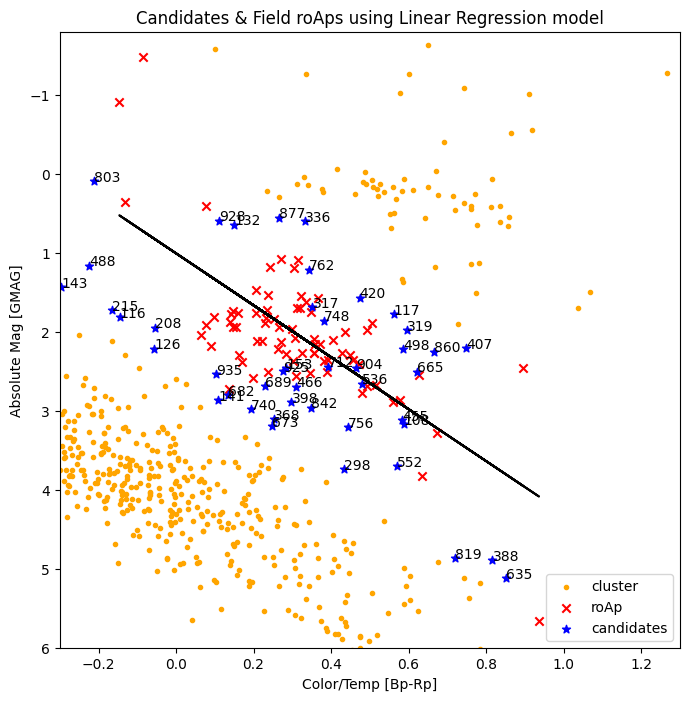

In [10]:
a1 = df['B-R']
b1 = df['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Linear Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a1,b1,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,predr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(df['ID']):
    plt.annotate(id, (a1[i],b1[i]))

plt.savefig('Figures/Linear-Candidates')
plt.show()

### 6. Showing which degree is best to fit to data for no under/over fitting

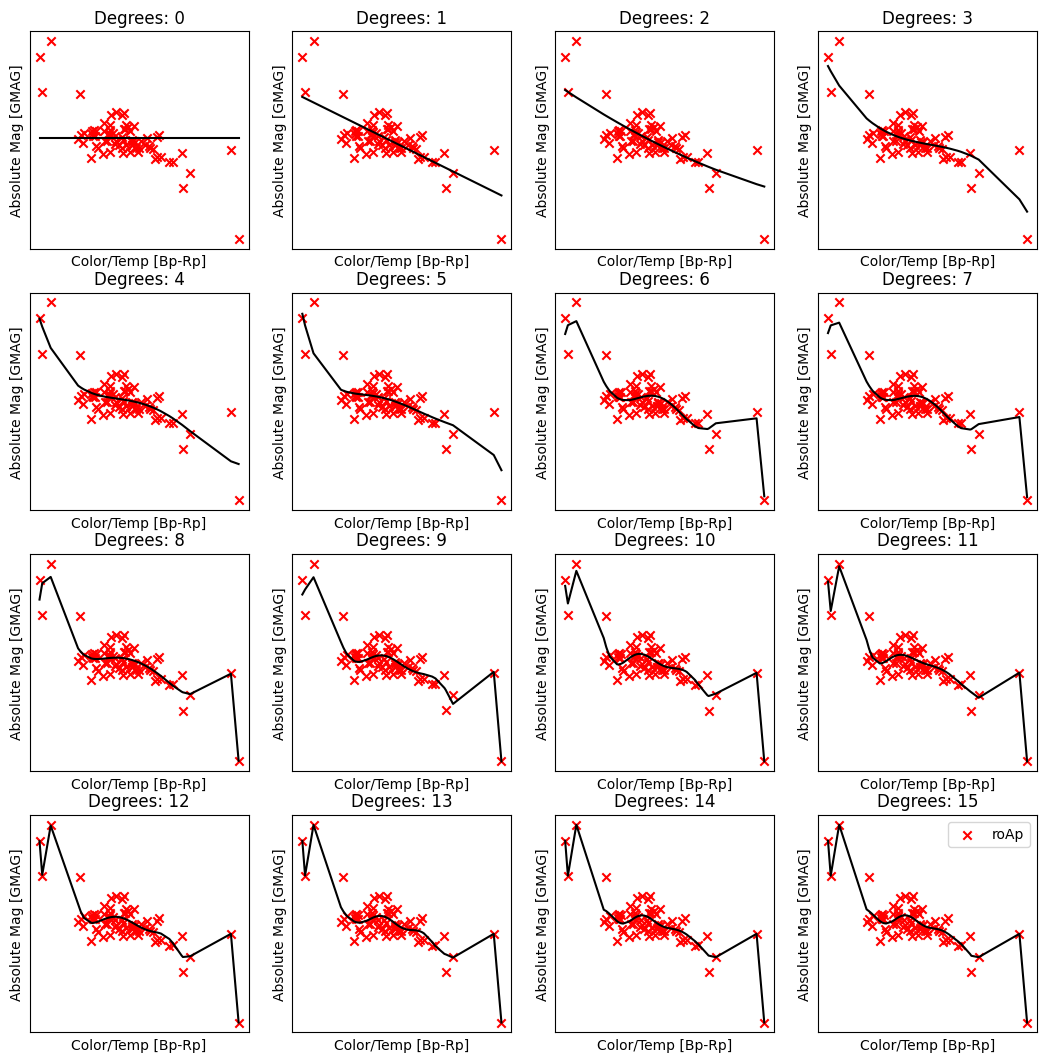

In [11]:
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
xarr = np.array(xs)

plt.figure(figsize=(13,13))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    polyi = PolynomialFeatures(degree=(i))
    regpi = LinearRegression()
    
    pfri = polyi.fit_transform(xtrain_r)
    pfi = polyi.fit_transform(xtrain)

    regpi.fit(pfri, ytrain_r)
    yfi = pd.Series(regpi.predict(pfri).flatten())
    ypredi = np.array(yfi[xs.index])

    plt.gca().invert_yaxis()
    plt.title(f'Degrees: {i}')
    plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
    plt.plot(xarr,ypredi,c='black')
    
    plt.ylabel('Absolute Mag [GMAG]')
    plt.xlabel('Color/Temp [Bp-Rp]')
    plt.savefig('Figures/ith-deg-Polynomial-roAp')
plt.legend()

### 7. Training and plottting the concatenated dataset using polynomial regression
        5 degrees being used, chosen from subplot

In [12]:
deg = 5
poly = PolynomialFeatures(degree=deg, include_bias=False)
regp = LinearRegression()

pfr = poly.fit_transform(xtrain_r)
pf = poly.fit_transform(xtrain)
regp.fit(pfr, ytrain_r)
print('')

#### ~ Predicting, calculating deviation, and exporting candidates then plotting

In [13]:
predp = regp.predict(pf)
predpr = regp.predict(pfr)

print(f'Intercept: {regp.intercept_} and Coefficients: {regp.coef_}')
print('The Mean Squared Error: %.2f' % mean_squared_error(ytrain,pred))
dist = np.abs(ytrain - predp)
print('Length of the deviation list:', len(dist))

Intercept: 1.3610410922781857 and Coefficients: [   7.07137756  -42.84577947  128.93353132 -161.38973538   72.75641212]
The Mean Squared Error: 11.59
Length of the deviation list: 846


In [14]:
print('Stars in NGC 2264 following the Polynomial regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Polynomial regression:
Deviation: 1.4948698767115738 | ID: 99 | GMAG: 3.334671 | B-R:  0.17730090930388476
Deviation: 1.3634390282772348 | ID: 107 | GMAG: 1.366215 | B-R:  0.5845720995488952
Deviation: 0.43220514187747705 | ID: 108 | GMAG: 3.168816 | B-R:  0.5871736591540849
Deviation: 0.8865860017977794 | ID: 117 | GMAG: 1.780438 | B-R:  0.5616495629624519
Deviation: 1.403845958645052 | ID: 126 | GMAG: 2.213628 | B-R:  -0.05574417314699416
Deviation: 1.1713814136118874 | ID: 132 | GMAG: 0.64592 | B-R:  0.1506624642911365
Deviation: 1.0957965605297264 | ID: 141 | GMAG: 2.864242 | B-R:  0.10923665279286392
Deviation: 0.5065780062023644 | ID: 153 | GMAG: 2.458177 | B-R:  0.2840983207511297
Deviation: 1.1143037670088294 | ID: 208 | GMAG: 1.948123 | B-R:  -0.053901048671004655
Deviation: 1.4515176429057752 | ID: 298 | GMAG: 3.741228 | B-R:  0.4324677225343978
Deviation: 1.391321405258644 | ID: 316 | GMAG: 1.335457 | B-R:  0.583500121405389
Deviation: 0.39288

In [15]:
print(len(cands))
dfp = pd.DataFrame(cands)
dfp.to_csv('Data/polynomial-candidates.csv',index=False,header=True)
dfp.describe()

48


,ID,Deviation,GMAG,B-R
count,48.000000,48.000000,48.000000,48.000000
mean,511.145833,0.939414,2.691661,0.410237
std,262.841671,0.397579,1.343360,0.276738
min,99.000000,0.079350,0.554031,-0.055744
25%,318.500000,0.654427,1.934959,0.221115
50%,482.000000,0.973532,2.569707,0.367454
75%,742.000000,1.266192,3.109308,0.585092
max,935.000000,1.494870,6.517113,1.054747


#### ~ Displaying graph of roAp candidates with field roAp's using 5 degree polynomial regression

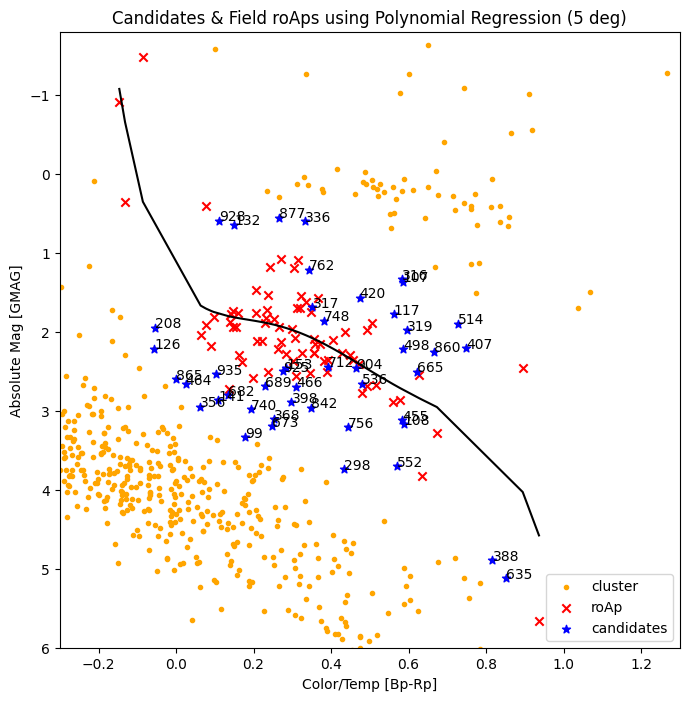

In [16]:
a2 = dfp['B-R']
b2 = dfp['GMAG']
# Flattening the series for the x-values and prediction values
xf = pd.Series(xtrain_r.flatten())
yf = pd.Series(predpr.flatten())
# Sorting
xs = xf.sort_values()
# Arraning into an array to plot
ypred = np.array(yf[xs.index])
xarr = np.array(xs)

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title(f'Candidates & Field roAps using Polynomial Regression ({deg} deg)')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a2,b2,marker='*',c='b',label='candidates')
plt.plot(xarr,ypred,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfp['ID']):
    plt.annotate(id, (a2[i],b2[i]))
    
plt.savefig(f'Figures/Polynomial-Candidates-{deg}deg')
plt.show()

### 8. Training and plotting concatenated set with Lasso regression

In [17]:
lreg = Lasso(alpha=.06)

lreg.fit(xtrain_r,ytrain_r)
lpred = lreg.predict(xtrain)
lpredr = lreg.predict(xtrain_r)

print("Regression Coefficient:", lreg.coef_[0])
dist = np.abs(ytrain - lpred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.6271201895985525
Length of the deviation list: 846


#### ~ The slope, coefficient, is very steep, as seen in the plot. This is a discrete value, determined from $\alpha$, here it is 0.06

In [18]:
print('Stars in NGC 2264 following the Lasso regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Lasso regression:
Deviation: 1.1065411411945054 | ID: 107 | GMAG: 1.366215 | B-R:  0.5845720995488952
Deviation: 0.6918268086474462 | ID: 108 | GMAG: 3.168816 | B-R:  0.5871736591540849
Deviation: 0.5325150037358342 | ID: 116 | GMAG: 1.817156 | B-R:  -0.14562297302498434
Deviation: 0.6550204191178921 | ID: 117 | GMAG: 1.780438 | B-R:  0.5616495629624519
Deviation: 1.452775396508851 | ID: 122 | GMAG: 2.590735 | B-R:  -0.23577082670579108
Deviation: 0.7827433938374684 | ID: 126 | GMAG: 2.213628 | B-R:  -0.05574417314699416
Deviation: 1.1208130132052623 | ID: 132 | GMAG: 0.64592 | B-R:  0.1506624642911365
Deviation: 1.1649137610540807 | ID: 141 | GMAG: 2.864242 | B-R:  0.10923665279286392
Deviation: 0.47432781073230834 | ID: 153 | GMAG: 2.458177 | B-R:  0.2840983207511297
Deviation: 0.5142394087906428 | ID: 208 | GMAG: 1.948123 | B-R:  -0.053901048671004655
Deviation: 0.4689541038850502 | ID: 215 | GMAG: 1.723426 | B-R:  -0.16416438154666183
Deviation: 0.86

In [19]:
print(len(cands))
dfl = pd.DataFrame(cands)
dfl.to_csv('Data/lasso-candidates.csv',index=False,header=True)
dfl.describe()

54


,ID,Deviation,GMAG,B-R
count,54.000000,54.000000,54.000000,54.000000
mean,512.907407,0.852889,2.193740,0.265593
std,267.232869,0.395137,0.802212,0.290689
min,107.000000,0.004225,0.094609,-0.235771
25%,316.250000,0.528913,1.737679,0.015716
50%,493.000000,0.870085,2.448784,0.280265
75%,746.000000,1.143480,2.775384,0.541082
max,935.000000,1.458767,3.700664,0.773143


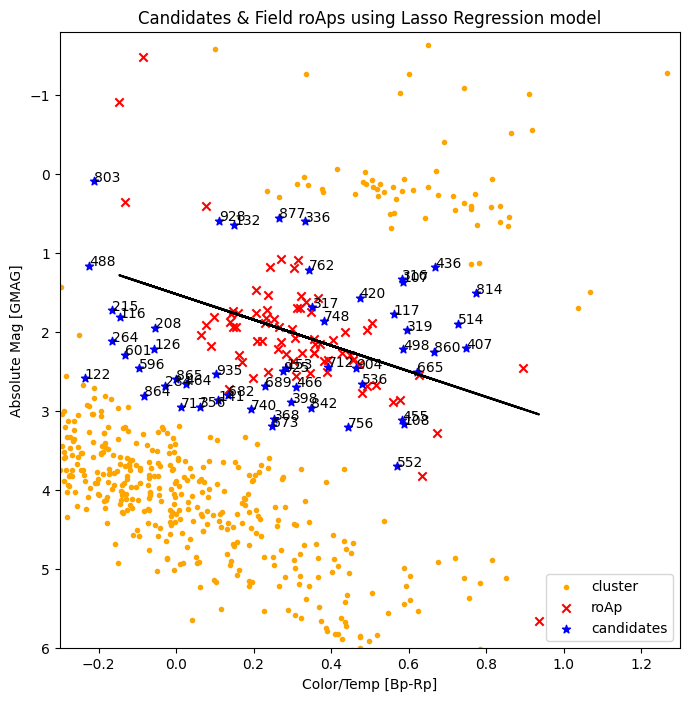

In [20]:
a3 = dfl['B-R']
b3 = dfl['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Lasso Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a3,b3,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfl['ID']):
    plt.annotate(id, (a3[i],b3[i]))
    
plt.savefig('Figures/Lasso-Candidates')
plt.show()

### 9. Elastic Net Regression

In [21]:
ereg = ElasticNet(alpha=.06)

ereg.fit(xtrain_r,ytrain_r)
epred = ereg.predict(xtrain)
epredr = ereg.predict(xtrain_r)

print("Regression Coefficient:", ereg.coef_[0])
dist = np.abs(ytrain - epred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 1.3426409485058814
Length of the deviation list: 846


In [22]:
print('Stars in NGC 2264 following the Elastic Net regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
min = (xr.min()) - 0.1
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max) & (xtrain[n]>min):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the Elastic Net regression:
Deviation: 1.4866965843649487 | ID: 99 | GMAG: 3.334671 | B-R:  0.17730090930388476
Deviation: 1.0285783928047318 | ID: 107 | GMAG: 1.366215 | B-R:  0.5845720995488952
Deviation: 0.7705296467393619 | ID: 108 | GMAG: 3.168816 | B-R:  0.5871736591540849
Deviation: 0.40275241203018286 | ID: 116 | GMAG: 1.817156 | B-R:  -0.14562297302498434
Deviation: 0.5835786565401488 | ID: 117 | GMAG: 1.780438 | B-R:  0.5616495629624519
Deviation: 1.2973676118019506 | ID: 122 | GMAG: 2.590735 | B-R:  -0.23577082670579108
Deviation: 0.6785494549114277 | ID: 126 | GMAG: 2.213628 | B-R:  -0.05574417314699416
Deviation: 1.1662885485564134 | ID: 132 | GMAG: 0.64592 | B-R:  0.1506624642911365
Deviation: 1.107653442286253 | ID: 141 | GMAG: 2.864242 | B-R:  0.10923665279286392
Deviation: 0.4668120065614467 | ID: 153 | GMAG: 2.458177 | B-R:  0.2840983207511297
Deviation: 0.41056980051677083 | ID: 208 | GMAG: 1.948123 | B-R:  -0.053901048671004655
Deviation:

In [23]:
print(len(cands))
dfe = pd.DataFrame(cands)
dfe.to_csv('Data/elastic-net-candidates.csv',index=False,header=True)
dfe.describe()

61


,ID,Deviation,GMAG,B-R
count,61.000000,61.000000,61.000000,61.000000
mean,498.573770,0.884748,2.224184,0.254369
std,263.125221,0.411514,0.795952,0.321206
min,99.000000,0.059736,0.094609,-0.238976
25%,316.000000,0.518127,1.723426,-0.029328
50%,466.000000,0.979456,2.461058,0.266716
75%,735.000000,1.251719,2.811002,0.561650
max,935.000000,1.491043,3.700664,1.037231


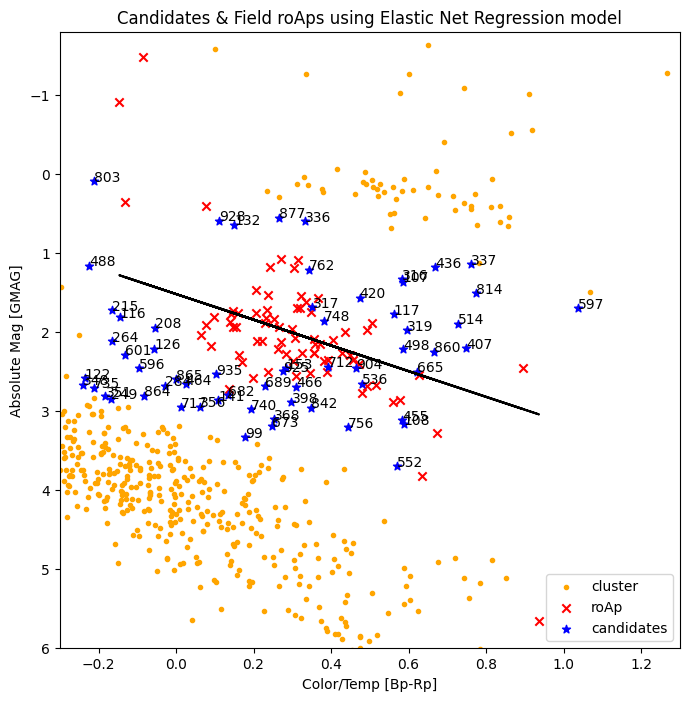

In [24]:
a4 = dfe['B-R']
b4 = dfe['GMAG']

plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps using Elastic Net Regression model')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a4,b4,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,lpredr,c='black')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(dfe['ID']):
    plt.annotate(id, (a4[i],b4[i]))
    
plt.savefig('Figures/Elastic-Net-Candidates')
plt.show()

### 10. Plotting and exporting all 3 regression model candidates, so we have new and repeated stars
        Still need to export the repeated and new stars; possibly a csv file for each, new, both, and all

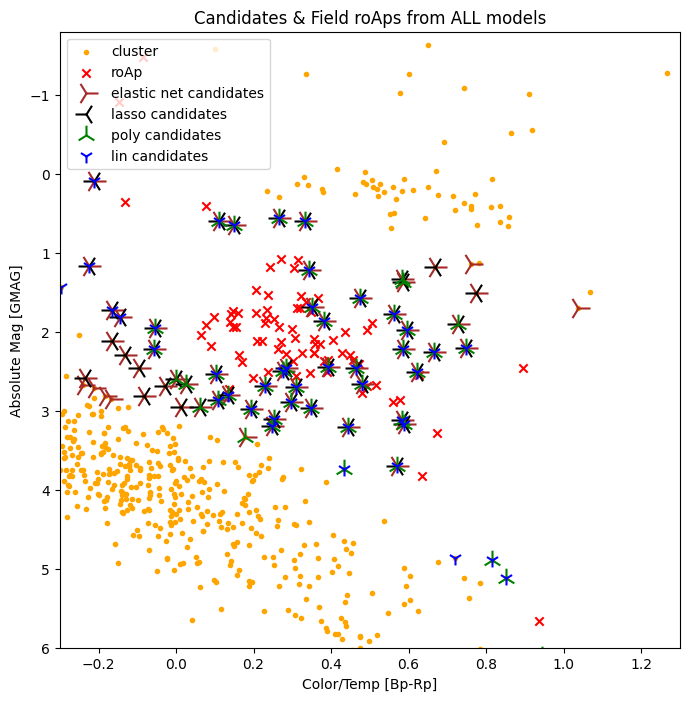

In [25]:
plt.figure(figsize=(8,8))
plt.ylim([-1.8,6])
plt.xlim([-0.3,1.3])
plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps from ALL models')

plt.scatter(xtrain,ytrain,marker='.',c='orange',label='cluster')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a4,b4,marker='4',s=300,c='brown',label='elastic net candidates')
plt.scatter(a3,b3,marker='3',s=250,c='black',label='lasso candidates')
plt.scatter(a2,b2,marker='2',s=200,c='g',label='poly candidates')
plt.scatter(a1,b1,marker='1',s=100,c='b',label='lin candidates')

plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()
    
plt.savefig('Figures/ALL-reg-Candidates')
plt.show()

In [36]:
#exporting new candidates to a CSV
# linear = df, poly = dfp, lasso = dfl, elasticnet = dfe
lin = df['ID']
poly = dfp['ID']
lasso = dfl['ID']
elasticnet = dfe['ID']

candidates = pd.DataFrame()

# candidates from all four
allfour = lin.combine_first(poly).combine_first(lasso).combine_first(elasticnet)
candidates['All Four'] = allfour

#combinations of three
lin_poly_lasso = lin.combine_first(poly).combine_first(lasso)
candidates['Linear - Polynomial - Lasso'] = lin_poly_lasso

lin_poly_elastic = lin.combine_first(poly).combine_first(elasticnet)
candidates['Linear - Polynomial - Elastic Net'] = lin_poly_elastic

poly_lasso_elastic = poly.combine_first(lasso).combine_first(elasticnet)
candidates['Polynomial - Lasso - Elastic Net'] = poly_lasso_elastic

lin_lasso_elastic = lin.combine_first(lasso).combine_first(elasticnet)
candidates['Linear - Lasso - Elastic Net'] = lin_lasso_elastic

#combinations of two
lin_poly = lin.combine_first(poly)
candidates['Linear - Polynomial'] = lin_poly

lin_lasso = lin.combine_first(lasso)
candidates['Linear - Lasso'] = lin_lasso

lin_elastic = lin.combine_first(elasticnet)
candidates['Linear - Elastic'] = lin_elastic

poly_lasso = poly.combine_first(lasso)
candidates['Polynomial - Lasso'] = poly_lasso

poly_elastic = poly.combine_first(elasticnet)
candidates['Polynomial - Elastic Net'] = poly_elastic

lasso_elastic = lasso.combine_first(elasticnet)
candidates['Lasso - Elastic Net'] = lasso_elastic

#singles
candidates['Linear'] = lin
candidates['Polynomial'] = poly
candidates['Lasso'] = lasso
candidates['Elastic Net'] = lasso

print(candidates)
candidates.to_csv('Data/total-candidates.csv',index=False,header=True)
candidates.describe()

    All Four  Linear - Polynomial - Lasso  Linear - Polynomial - Elastic Net  \
0      108.0                        108.0                              108.0   
1      116.0                        116.0                              116.0   
2      117.0                        117.0                              117.0   
3      126.0                        126.0                              126.0   
4      132.0                        132.0                              132.0   
..       ...                          ...                                ...   
56     877.0                          NaN                              877.0   
57     904.0                          NaN                              904.0   
58     925.0                          NaN                              925.0   
59     928.0                          NaN                              928.0   
60     935.0                          NaN                              935.0   

    Polynomial - Lasso - Elastic Net  L

,All Four,Linear - Polynomial - Lasso,Linear - Polynomial - Elastic Net,Polynomial - Lasso - Elastic Net,Linear - Lasso - Elastic Net,Linear - Polynomial,Linear - Lasso,Linear - Elastic,Polynomial - Lasso,Polynomial - Elastic Net,Lasso - Elastic Net,Linear,Polynomial,Lasso,Elastic Net
count,61.000000,54.000000,61.000000,61.000000,61.000000,49.000000,54.000000,61.000000,54.000000,61.000000,61.000000,49.000000,48.000000,54.000000,54.000000
mean,597.213115,558.000000,589.213115,594.540984,597.213115,521.693878,558.000000,589.213115,554.981481,584.754098,557.295082,521.693878,511.145833,512.907407,512.907407
std,287.420604,282.420602,279.727434,283.533630,287.420604,271.092328,282.420602,279.727434,277.500875,274.167325,280.409245,271.092328,262.841671,267.232869,267.232869
min,108.000000,108.000000,108.000000,99.000000,108.000000,108.000000,108.000000,108.000000,99.000000,99.000000,107.000000,108.000000,99.000000,107.000000,107.000000
25%,368.000000,323.250000,368.000000,368.000000,368.000000,317.000000,323.250000,368.000000,341.000000,368.000000,319.000000,317.000000,318.500000,316.250000,316.250000
50%,673.000000,564.000000,673.000000,665.000000,673.000000,498.000000,564.000000,673.000000,541.000000,665.000000,552.000000,498.000000,482.000000,493.000000,493.000000
75%,877.000000,833.250000,842.000000,865.000000,877.000000,756.000000,833.250000,842.000000,828.500000,842.000000,842.000000,756.000000,742.000000,746.000000,746.000000
max,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000,935.000000
